In [1]:
# ===========================
# Install Qiskit, Aer and pylatexenc
# ===========================
!pip install qiskit --quiet
!pip install qiskit-aer --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 99.7 MB/s eta 0:00:00


SINGLE-QUBIT EXAMPLES (apply H to given initial states)

--- |0> ---
Statevector after H (exact):
[0.70710678+0.j 0.70710678+0.j]


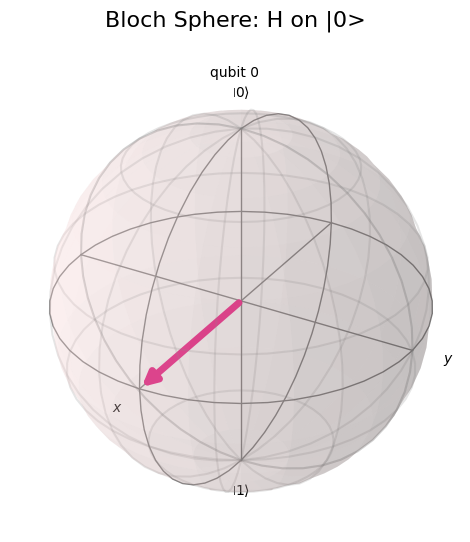

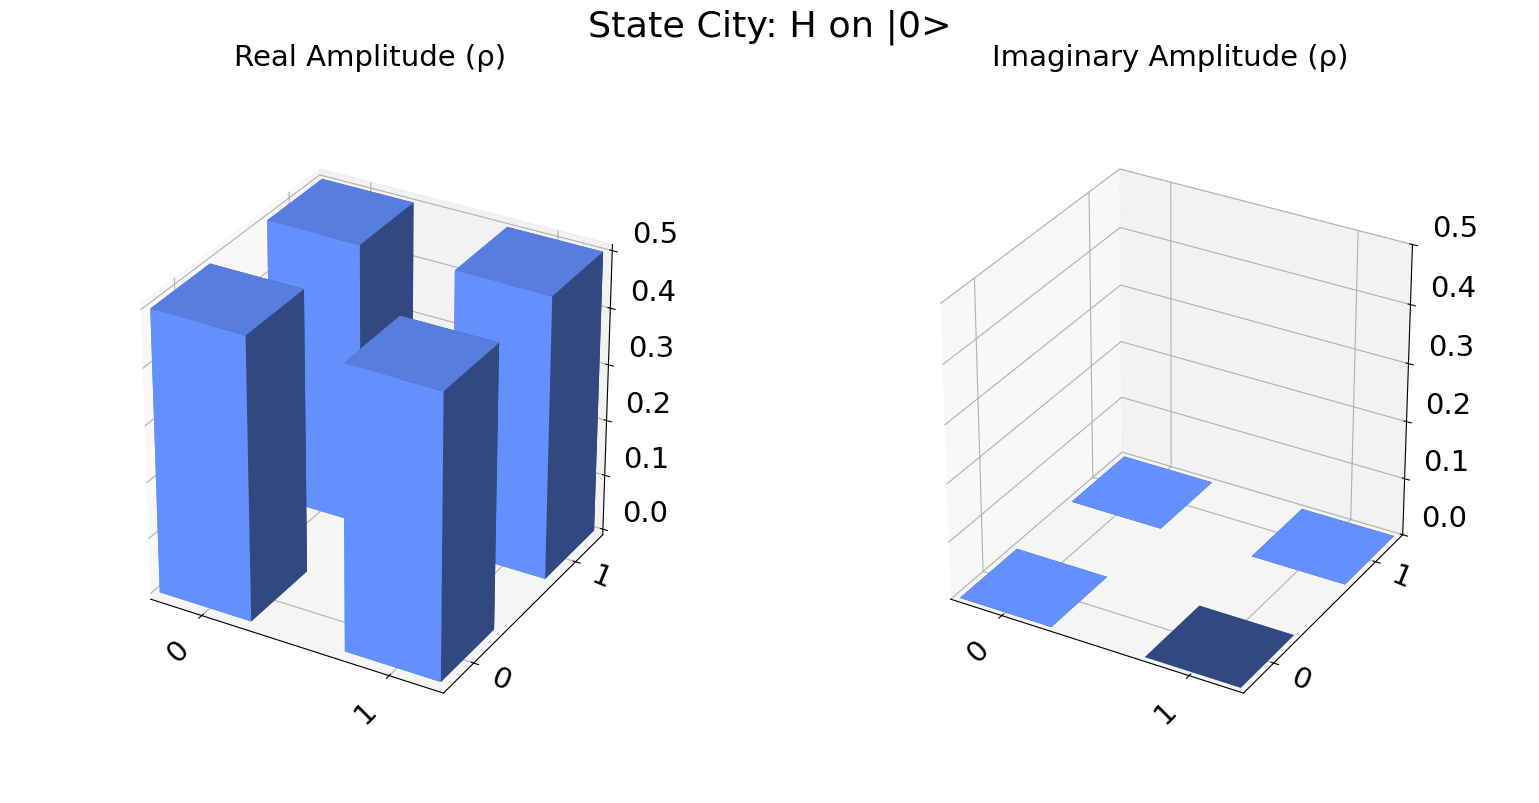

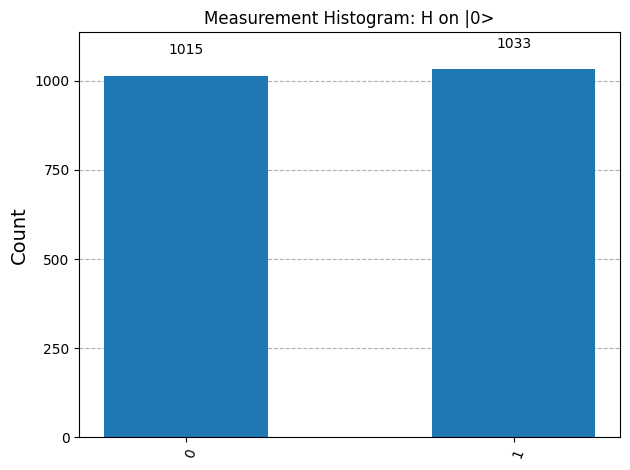



--- |1> ---
Statevector after H (exact):
[ 0.70710678+0.j -0.70710678+0.j]


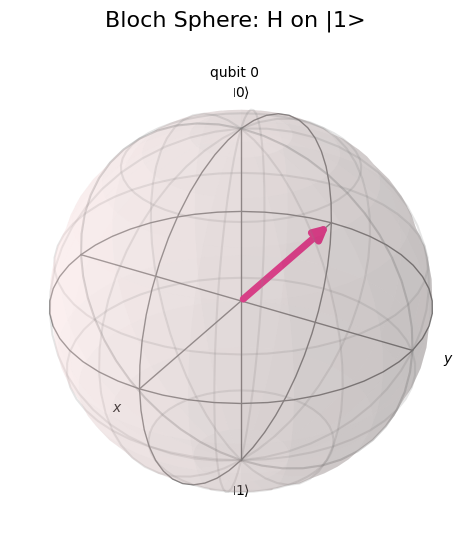

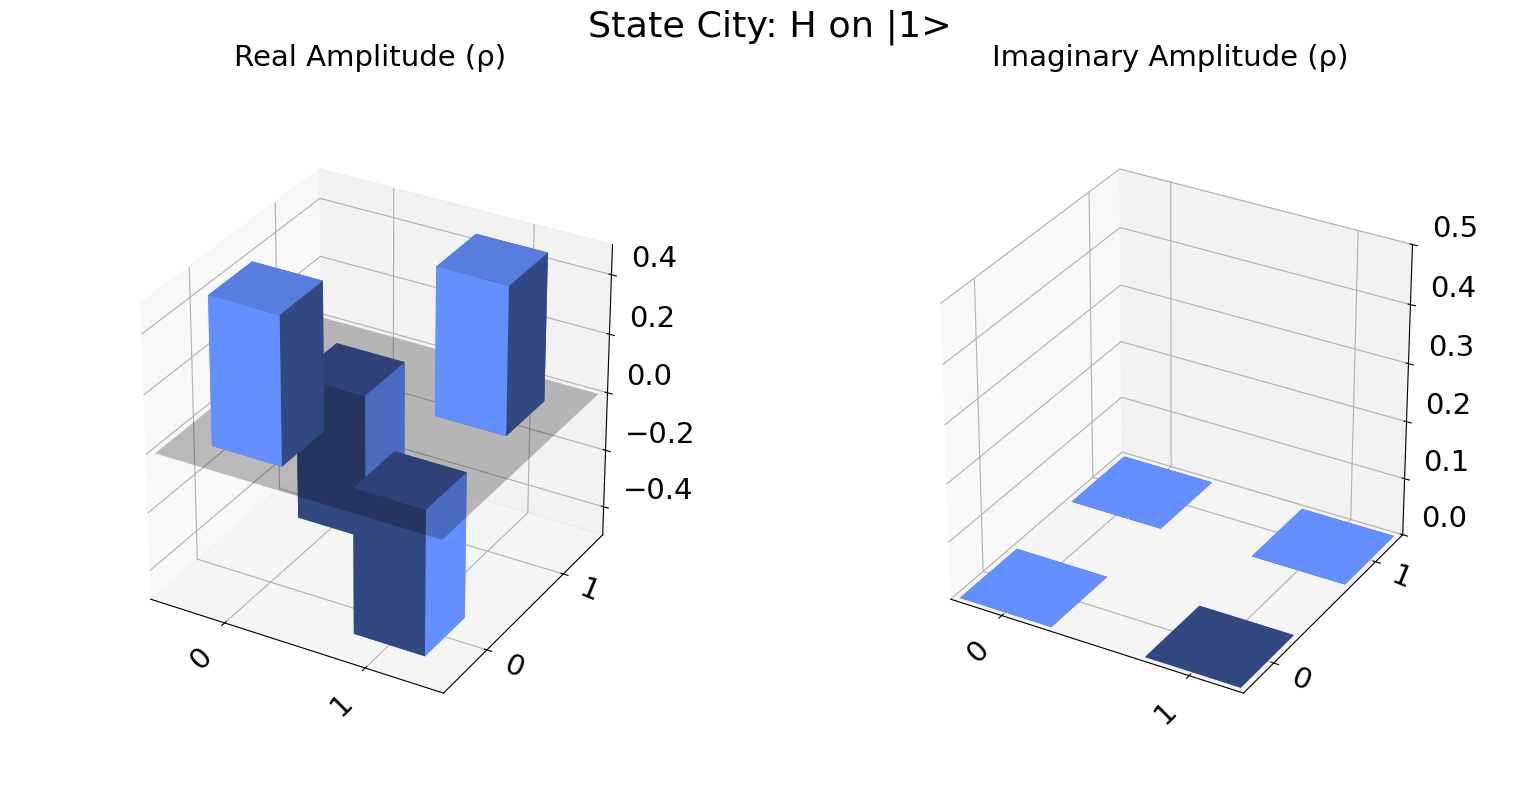

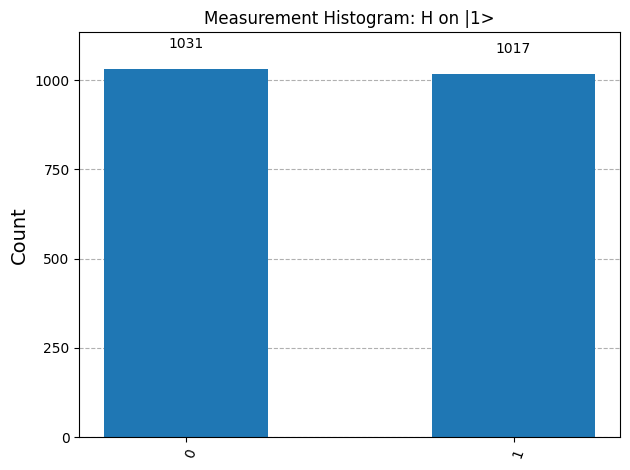



--- |+> ---
Statevector after H (exact):
[1.+0.j 0.+0.j]


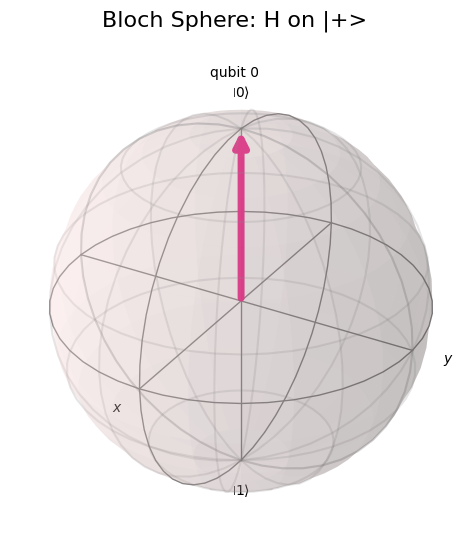

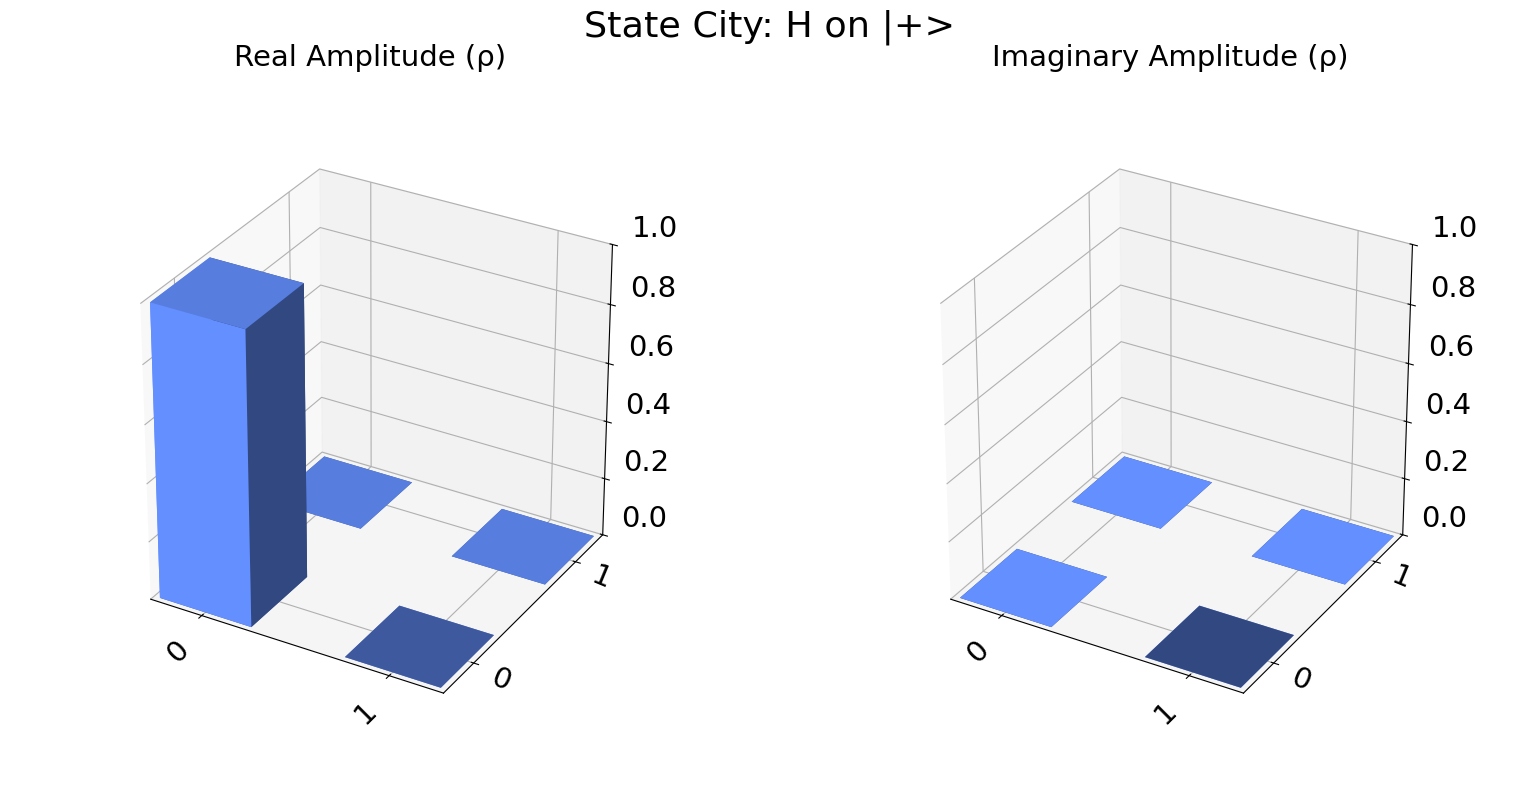

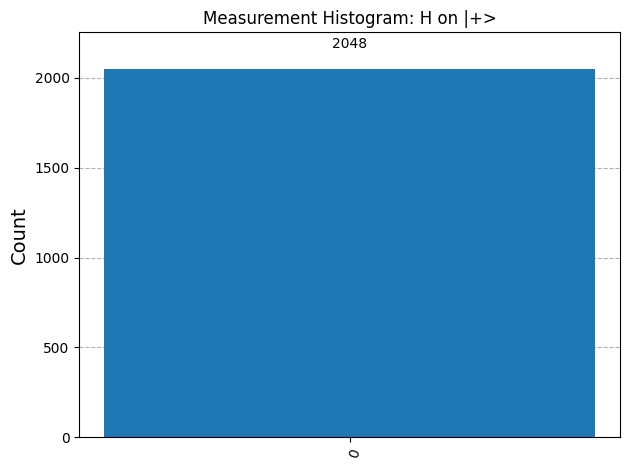



--- |-> ---
Statevector after H (exact):
[0.+0.j 1.+0.j]


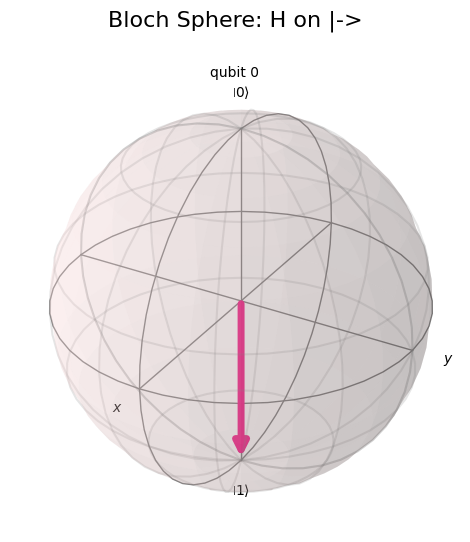

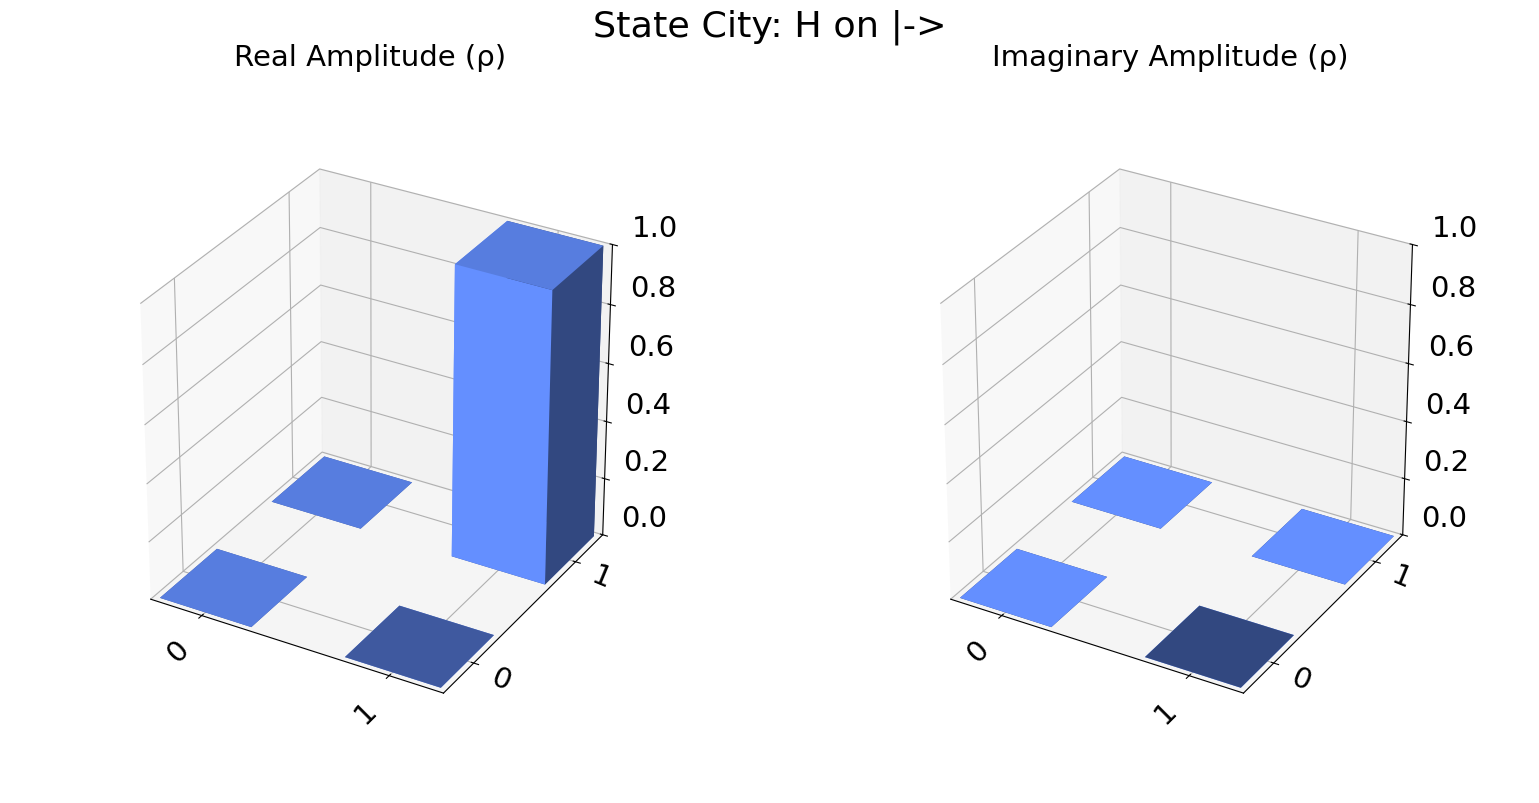

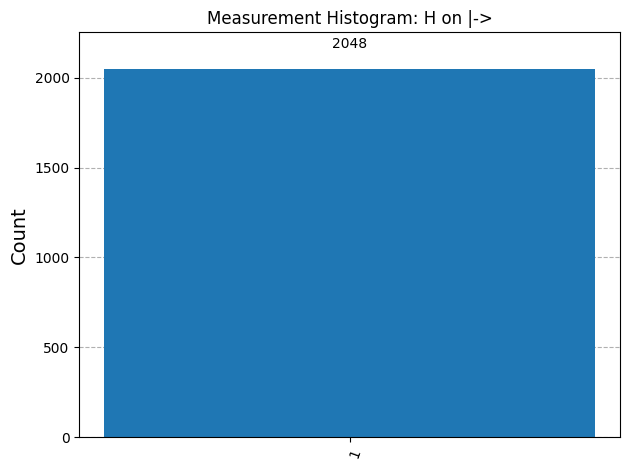



3-QUBIT: Apply H⊗H⊗H to |000> (uniform superposition)

Statevector amplitudes (ordering |000>..|111>):
[0.353553+0.j 0.353553+0.j 0.353553+0.j 0.353553+0.j 0.353553+0.j
 0.353553+0.j 0.353553+0.j 0.353553+0.j]
Expected amplitude magnitude: 0.35355339059327373


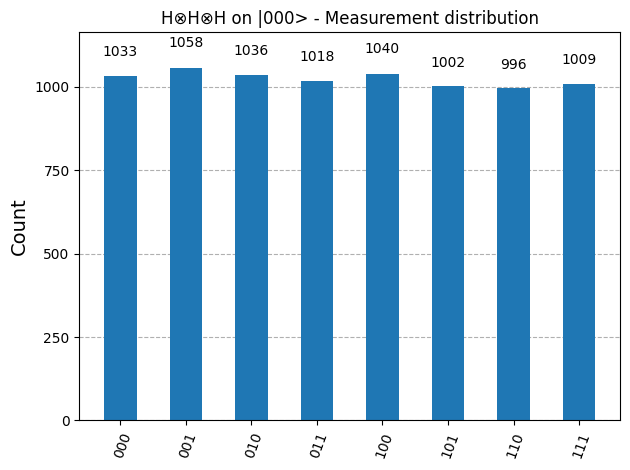


GHZ PREPARATION: H on q0, CX(q0->q1), CX(q0->q2)

GHZ statevector amplitudes (|000>..|111>):
[0.707107+0.j 0.      +0.j 0.      +0.j 0.      +0.j 0.      +0.j
 0.      +0.j 0.      +0.j 0.707107+0.j]
Should be nonzero only at |000> and |111> and equal amplitudes (1/sqrt2).


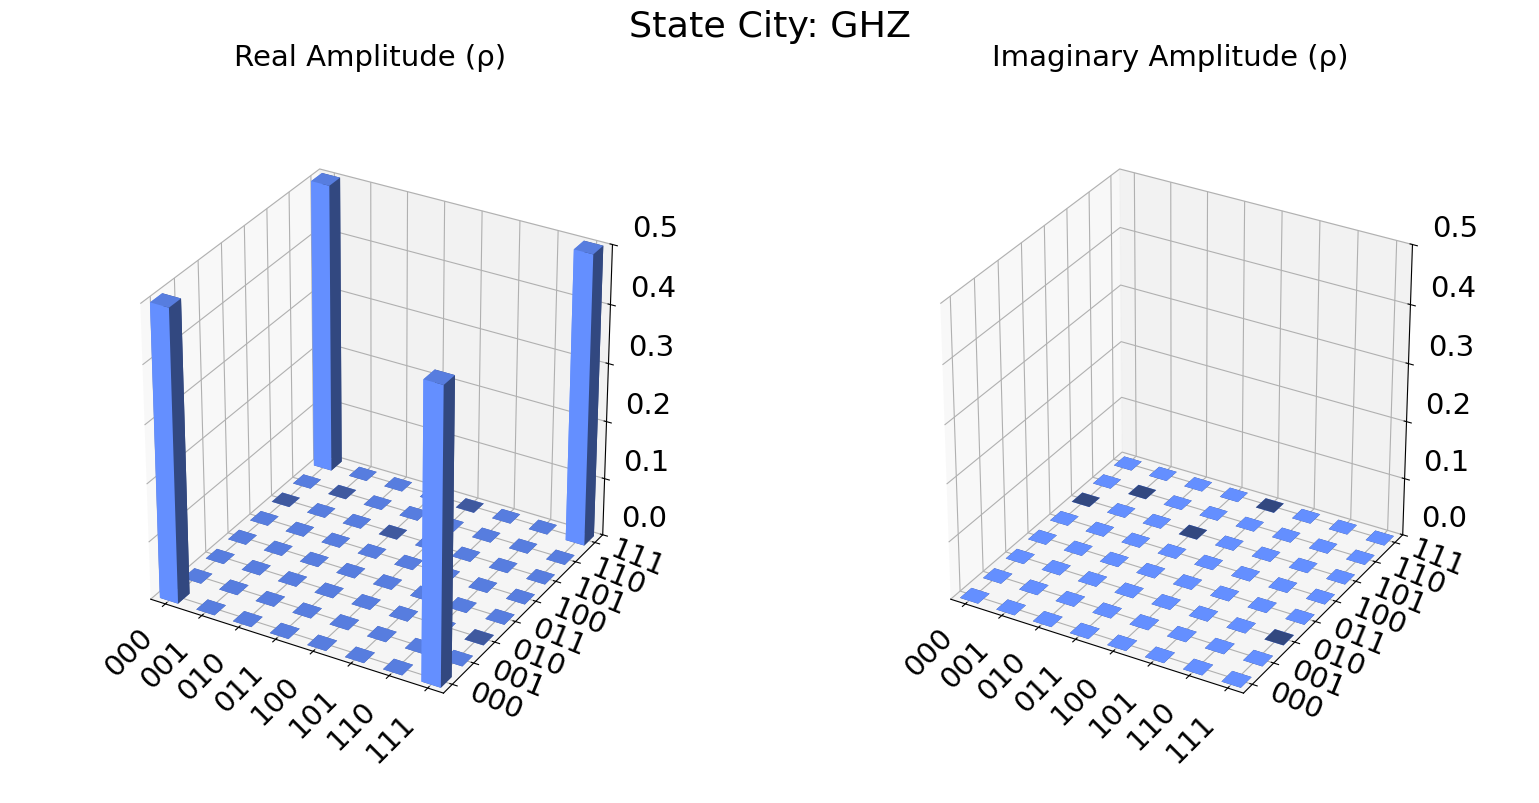

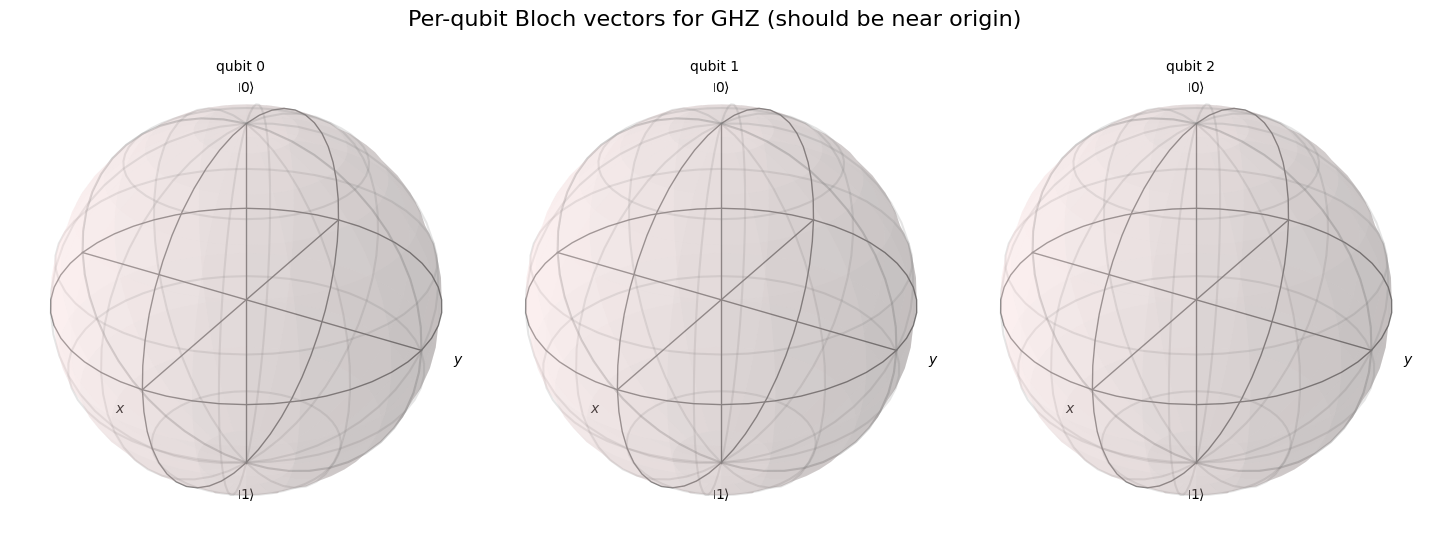

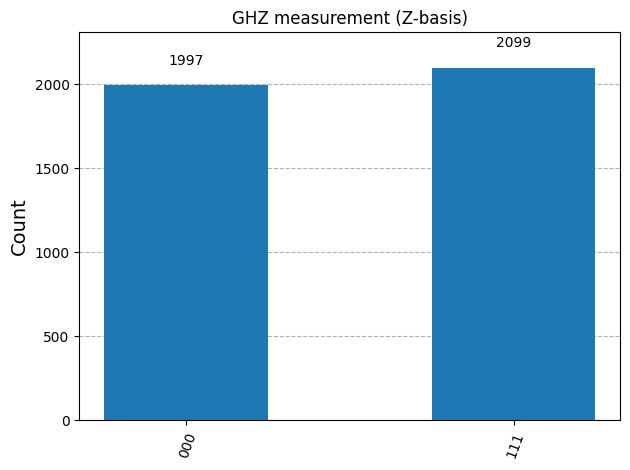

GHZ measurement counts: {'000': 1997, '111': 2099}
Reduced density matrix for qubit 0:
 [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]
Eigenvalues (should be ~[0.5,0.5] for maximally mixed): [0.5+0.j 0.5+0.j]

Reduced density matrix for qubit 1:
 [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]
Eigenvalues (should be ~[0.5,0.5] for maximally mixed): [0.5+0.j 0.5+0.j]

Reduced density matrix for qubit 2:
 [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]
Eigenvalues (should be ~[0.5,0.5] for maximally mixed): [0.5+0.j 0.5+0.j]

APPLY H TWICE on |1> — verification H^2 = I

Resulting statevector (should equal |1>): [0.+0.j 1.+0.j]
H^2|1> equals |1> up to global phase? -> True

BLOCH NOTES:
- H maps |0> (north pole) to |+> (equator +X) and |1> (south pole) to |-> (equator -X).
- The per-qubit Bloch vectors for GHZ are near the origin (maximally mixed marginals) even though the global state is pure and entangled.
- Use the displayed Bloch plots above to visually verify these facts.



In [3]:
# ============================================================
# HADAMARD VISUALIZATION & ANALYSIS (Qiskit 2.x) - All tasks
# ============================================================
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_state_city, plot_histogram
from qiskit_aer import AerSimulator
from IPython.display import display
import matplotlib.pyplot as plt

# -------------------------
# Helper: partial trace via numpy (works for up to small n)
# -------------------------
def reduced_density_from_statevector(psi, keep, num_qubits):
    """
    psi : full statevector (1D complex array of length 2**num_qubits)
    keep: list of qubit indices to KEEP (0 = most-significant qubit if using computational ordering)
    returns reduced density matrix as numpy array of shape (2**len(keep), 2**len(keep))
    """
    # normalize (in case)
    psi = np.asarray(psi, dtype=complex).reshape(-1)
    n = num_qubits
    if psi.size != 2**n:
        raise ValueError("Statevector length doesn't match num_qubits")

    # reshape to tensor (2,2,...,2)
    psi_tensor = psi.reshape([2]*n)
    # create density tensor with shape (2,...,2,2,...,2)
    rho = np.tensordot(psi_tensor, np.conjugate(psi_tensor), axes=0)
    # axes: first n are bra indices (rows), last n are ket indices (cols)
    # We will trace out qubits not in keep. Tracing reduces pair of axes (i, n+i).
    # To keep index ordering stable, sort and remove from highest to lowest.
    keep_set = set(keep)
    # indices to trace out:
    trace_out = [i for i in range(n) if i not in keep_set]
    # sort descending so axis indices remain correct after successive traces
    for i in sorted(trace_out, reverse=True):
        rho = np.trace(rho, axis1=i, axis2=n + i)
        # after trace, shape loses two axes; new n reduces by 1 each trace but because we
        # go descending we don't need to adjust axis indices.
        n -= 1

    # Now rho shape is (2,)*len(keep) + (2,)*len(keep)
    k = len(keep)
    rho = rho.reshape((2**k, 2**k))
    return rho

# -------------------------
# Utility: display statevector and plots
# -------------------------
sim = AerSimulator()

def show_single_qubit_state(init_vec, label):
    # Build circuit to prepare and apply H then get statevector object
    qc_state = QuantumCircuit(1)
    qc_state.initialize(init_vec, 0)
    qc_state.h(0)
    sv = Statevector.from_instruction(qc_state)
    print(f"--- {label} ---")
    print("Statevector after H (exact):")
    # show as exact symbolic-ish (sqrt fractions) if simple, otherwise numeric
    print(sv.data)
    display(plot_bloch_multivector(sv, title=f"Bloch Sphere: H on {label}"))
    display(plot_state_city(sv, title=f"State City: H on {label}"))
    # Also show measurement histogram from circuit with measurement
    qc = QuantumCircuit(1,1)
    qc.initialize(init_vec, 0)
    qc.h(0)
    qc.measure(0,0)
    qc_t = transpile(qc, sim)
    result = sim.run(qc_t, shots=2048).result()
    counts = result.get_counts()
    display(plot_histogram(counts, title=f"Measurement Histogram: H on {label}"))
    print("\n")
    return sv

# -------------------------
# 1) Single-qubit predictions & plots
# -------------------------
print("SINGLE-QUBIT EXAMPLES (apply H to given initial states)\n")

# |0>, |1>, |+>, |->
ket0 = np.array([1,0], dtype=complex)
ket1 = np.array([0,1], dtype=complex)
ket_plus = np.array([1/np.sqrt(2), 1/np.sqrt(2)], dtype=complex)
ket_minus = np.array([1/np.sqrt(2), -1/np.sqrt(2)], dtype=complex)

sv0 = show_single_qubit_state(ket0, "|0>")
sv1 = show_single_qubit_state(ket1, "|1>")
sv_plus = show_single_qubit_state(ket_plus, "|+>")
sv_minus = show_single_qubit_state(ket_minus, "|->")

# -------------------------
# 2) 3-qubit H⊗H⊗H on |000>
# -------------------------
print("3-QUBIT: Apply H⊗H⊗H to |000> (uniform superposition)\n")
qc_h3 = QuantumCircuit(3,3)
# default state is |000>, apply H to all three qubits
qc_h3.h([0,1,2])
sv_h3 = Statevector.from_instruction(qc_h3)
print("Statevector amplitudes (ordering |000>..|111>):")
# show numeric with sqrt(8) normalization
print(np.round(sv_h3.data, 6))
# Amplitudes should be 1/sqrt(8)
print("Expected amplitude magnitude:", 1/np.sqrt(8))
# measurement histogram
qc_h3_m = qc_h3.copy()
qc_h3_m.measure([0,1,2], [0,1,2])
qc_h3_t = transpile(qc_h3_m, sim)
result_h3 = sim.run(qc_h3_t, shots=8192).result()
counts_h3 = result_h3.get_counts()
display(plot_histogram(counts_h3, title="H⊗H⊗H on |000> - Measurement distribution"))

# -------------------------
# 3) H + CX + CX (GHZ) on 3 qubits and analyze correlations
# -------------------------
print("\nGHZ PREPARATION: H on q0, CX(q0->q1), CX(q0->q2)\n")
qc_ghz = QuantumCircuit(3,3)
qc_ghz.h(0)
qc_ghz.cx(0,1)
qc_ghz.cx(0,2)
sv_ghz = Statevector.from_instruction(qc_ghz)
print("GHZ statevector amplitudes (|000>..|111>):")
print(np.round(sv_ghz.data, 6))
print("Should be nonzero only at |000> and |111> and equal amplitudes (1/sqrt2).")

# display state city + bloch vectors per qubit
display(plot_state_city(sv_ghz, title="State City: GHZ"))
display(plot_bloch_multivector(sv_ghz, title="Per-qubit Bloch vectors for GHZ (should be near origin)"))

# measurement histogram (computational)
qc_ghz_m = qc_ghz.copy()
qc_ghz_m.measure([0,1,2], [0,1,2])
qc_ghz_t = transpile(qc_ghz_m, sim)
result_ghz = sim.run(qc_ghz_t, shots=4096).result()
counts_ghz = result_ghz.get_counts()
display(plot_histogram(counts_ghz, title="GHZ measurement (Z-basis)"))

print("GHZ measurement counts:", counts_ghz)

# Compute reduced density matrices for each individual qubit (to show local mixedness)
psi = sv_ghz.data  # full statevector length 8
num_qubits = 3
for q in range(num_qubits):
    rho_q = reduced_density_from_statevector(psi, keep=[q], num_qubits=num_qubits)
    # eigenvalues to show mixedness
    eigvals = np.linalg.eigvals(rho_q)
    print(f"Reduced density matrix for qubit {q}:\n", np.round(rho_q, 6))
    print(f"Eigenvalues (should be ~[0.5,0.5] for maximally mixed): {np.round(eigvals,6)}\n")

# -------------------------
# 4) Apply H twice on |1> and verify
# -------------------------
print("APPLY H TWICE on |1> — verification H^2 = I\n")
qc_h2 = QuantumCircuit(1)
qc_h2.initialize(ket1, 0)
qc_h2.h(0)
qc_h2.h(0)
sv_h2 = Statevector.from_instruction(qc_h2)
print("Resulting statevector (should equal |1>):", np.round(sv_h2.data,6))

# For clarity, check vector equality up to global phase:
def equal_up_to_global_phase(v1, v2, tol=1e-8):
    v1 = np.asarray(v1, dtype=complex).reshape(-1)
    v2 = np.asarray(v2, dtype=complex).reshape(-1)
    # normalize
    if np.linalg.norm(v1) == 0 or np.linalg.norm(v2) == 0:
        return False
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    # compute relative phase
    # find index of max magnitude entry to compute phase robustly
    idx = np.argmax(np.abs(v2))
    phase = v2[idx] / v1[idx] if np.abs(v1[idx])>1e-12 else 1
    return np.allclose(v2, v1 * phase, atol=tol)

print("H^2|1> equals |1> up to global phase? ->", equal_up_to_global_phase(sv_h2.data, ket1))

# -------------------------
# 5) Bloch-sphere observations summary
# -------------------------
print("\nBLOCH NOTES:")
print("- H maps |0> (north pole) to |+> (equator +X) and |1> (south pole) to |-> (equator -X).")
print("- The per-qubit Bloch vectors for GHZ are near the origin (maximally mixed marginals) even though the global state is pure and entangled.")
print("- Use the displayed Bloch plots above to visually verify these facts.\n")

